In [1]:
from astropy.io import fits #astropy modules for FITS IO
import numpy as np #numpy gives us better array management 
from scipy import interpolate #spline interpolation
import os #checking status of requested files

In [2]:
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting
import matplotlib.pyplot as plt
#next line is to show plots inline with jupyter
#%matplotlib inline 
from matplotlib.colors import LogNorm #for better display of FITS images

In [3]:
%matplotlib inline

In [4]:
import spgen as spgen #Python Routines for SpecGen Routines

In [5]:
# For Debuging
import importlib

In [48]:
importlib.reload(spgen) 

<module 'spgen' from '/home/rowe/Documents/jwst/jwst-mtl/SOSS/specgen/spgen.py'>

## Notebook Parameters  
These parameters set up the work environment.

In [7]:
workdir='/data/JWST/' #root folder for local files

## Model Parameters

In [41]:
pars=spgen.ModelPars()              #Set up default parameters
filename=workdir+'simpars.txt'      #location of file for parameter import 
pars=spgen.read_pars(filename,pars) #read in parameter file

Not found:  rprstype1 9 rprstype 1
Linenumber:  42


## Get Instrument Response 

In [42]:
response_file=workdir+'tables/NIRISS_Throughput_STScI.fits'
reponse_ld,reponse_n0,reponse_n1,reponse_n2,reponse_n3,quantum_yield=spgen.readresponse(response_file)

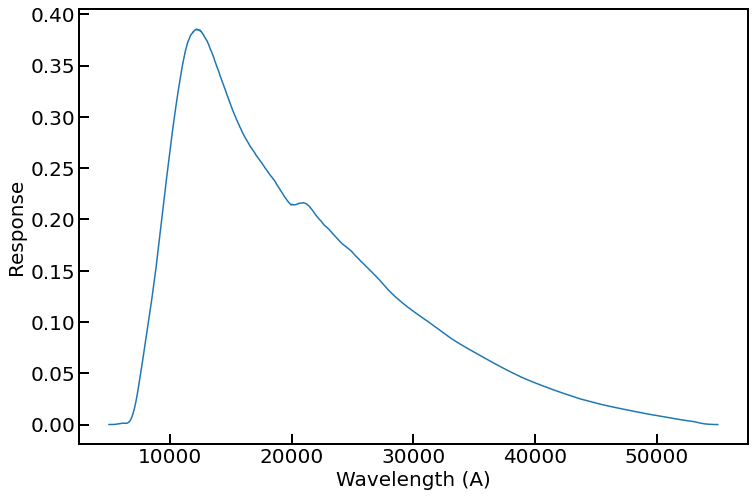

In [47]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)

ax.plot(reponse_ld,reponse_n1)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Response')

plt.show()

## Read in Stellar Atmosphere

In [43]:
starmodel_wv,starmodel_flux=spgen.readstarmodel(workdir+pars.modelfile,pars.nmodeltype)

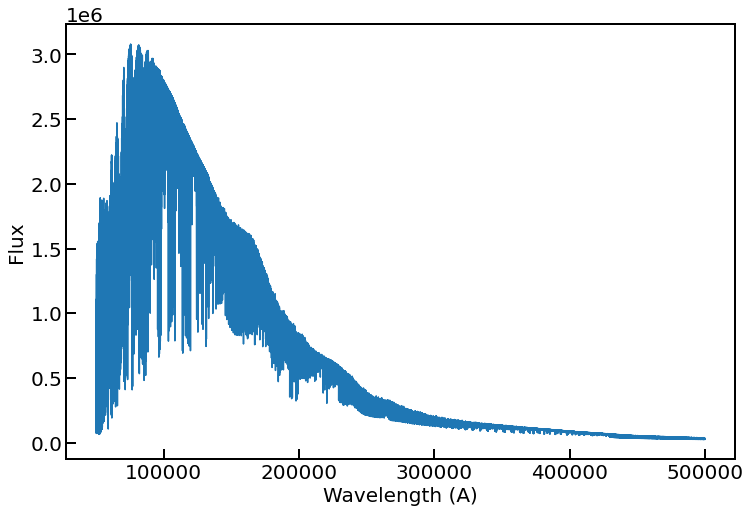

In [44]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)

ax.plot(starmodel_wv,starmodel_flux)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux')

plt.show()

## Read in Planet atmosphere

In [45]:
pmodeltype=2
planetmodel_wv,planetmodel_depth=spgen.readplanetmodel(workdir+pars.pmodelfile[0],pmodeltype)

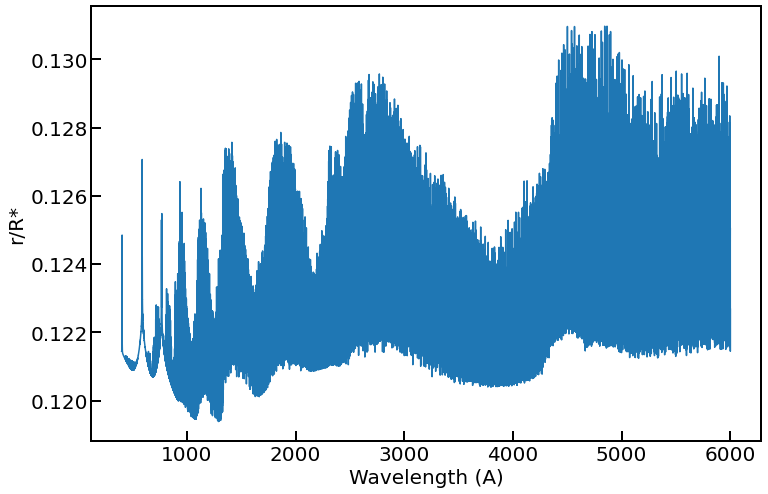

In [46]:
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)

ax.plot(planetmodel_wv/10,planetmodel_depth)

ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('r/R*')

plt.show()

In [52]:
print(spgen.p2w.__doc__)

Usage: w=p2w(p,noversample,ntrace) Converts x-pixel (p) to wavelength (w)
    Inputs:
      p : pixel value along dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      w : wavelength (A)
    


In [53]:
print(spgen.w2p.__doc__)

Usage: p=w2p(w,noversample,ntrace) Converts wavelength (w) to x-pixel (p)
    Inputs:
      w : wavelength (A)
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      p : pixel value along dispersion axis (float) on oversampled grid.

    


In [55]:
print(spgen.ptrace.__doc__)

given x-pixel, return y-position based on trace
    Usage:
    py = ptrace(px,noversample,ntrace)

    Inputs:
      px : pixel on dispersion axis (float) on oversampled grid.
      noversample : oversampling factor (integer 10 >= 1)
      ntrace : order n=1,2,3 

    Outputs:
      py : pixel on spatial axis (float) on oversampled grid.
    
